### Imports

In [224]:
import pandas as pd
from pandasql import sqldf
import time
import matplotlib.pylab as plt
import numpy as mp


##Spacy function
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame

## Train and test
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

## Performance
from sklearn import metrics
from sklearn.metrics import classification_report

## Models
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier



### Dataset original

In [2]:
df = pd.read_csv('cnnchile_7000.csv')
df = df.drop(["country","media_outlet", "url","date","title"],1)

q="""SELECT category, count(*) FROM df GROUP BY category ORDER BY count(*) DESC;"""
result=sqldf(q)
result

,category,count(*)
0,tendencias,1000
1,tecnologias,1000
2,pais,1000
3,mundo,1000
4,economia,1000
5,deportes,1000
6,cultura,1000


### Test and Train Split

In [5]:
## PRUEBAS REALES

X = df['text'].astype(str)
ylabels = df['category'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.25, random_state=0)


" \nX = df_train['text'].astype(str)\nylabels = df_train['category'].astype(str)\n\nX_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.25, random_state=0)\n"

### Spacy function

In [6]:
nlp = spacy.load("es_core_news_md")
def feature_extraction(text):
    
    mytokens = nlp(text)

    #Guardamos las palabras como características si corresponden a ciertas categorias gramaticaless
    mytokens = [ word for word in mytokens if word.pos_ in ["NOUN", "ADJ", "VERB"] ]
    
    #Transformamos las palabras en minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # return preprocessed list of tokens
    return mytokens

### Regresión logistica utilizando CountVectorizer vs TfidfVectorizer 


Al usar **countVectorizer**, utilizamos un enfoque `bag of word` donde cada palabra tiene la cantidad de veces que la palabra aparece en el texto (count)

Al usar **TfidfVectorizer** cambiamos el enfoque **countVectorizer** a un enfoque `Term frequency (tf)` y `Inverse data frequency (idf)` por lo cual a la estructura anterior se remplaza el enfoque de conteo por la frecuencia que tenga esa palabra en el texto de la fila.

Este enfoque es importnate debido a que disminuimos la importnancia de palabras comunes dentro de nuestro bag of words, asi por ejemplo palabras como *"el, la, como"* son menos propensas a afectar en el resultado final

In [7]:
bow_vector = CountVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

tfidf_vector = TfidfVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

In [228]:
model_1 = LogisticRegression(max_iter=1000)

pipe1 = Pipeline([('vectorizing', bow_vector),
                 ('learning', model_1)])


pipe2 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_1)])

In [9]:
pipe1.fit(X_train,y_train)

pipe2.fit(X_train,y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning', LogisticRegression(max_iter=1000))])

In [10]:
predicted_model_1 = pipe1.predict(X_test) 

In [11]:
predicted_model_2 = pipe2.predict(X_test)

In [12]:
print("Logistic Regression using CountVectorizer:",metrics.accuracy_score(y_test, predicted_model_1))

print("Logistic Regression using TfidfVectorizer:",metrics.accuracy_score(y_test, predicted_model_2))

Logistic Regression using CountVectorizer: 0.7222857142857143
Logistic Regression using TfidfVectorizer: 0.772


In [13]:
print("Matriz de confusión para CountVectorizer: ")
print(classification_report(y_test, predicted_model_1))

Matriz de confusión para CountVectorizer: 
              precision    recall  f1-score   support

     cultura       0.59      0.97      0.74       250
    deportes       0.86      0.78      0.82       255
    economia       0.74      0.82      0.78       273
       mundo       0.72      0.71      0.72       238
        pais       0.80      0.58      0.68       250
 tecnologias       0.69      0.72      0.70       252
  tendencias       0.79      0.43      0.56       232

    accuracy                           0.72      1750
   macro avg       0.74      0.72      0.71      1750
weighted avg       0.74      0.72      0.72      1750



In [14]:
print("Matriz de confusión para TfidfVectorizer: ")
print(classification_report(y_test, predicted_model_2))

Matriz de confusión para TfidfVectorizer: 
              precision    recall  f1-score   support

     cultura       0.87      0.90      0.89       250
    deportes       0.85      0.87      0.86       255
    economia       0.77      0.78      0.78       273
       mundo       0.72      0.72      0.72       238
        pais       0.78      0.68      0.72       250
 tecnologias       0.72      0.72      0.72       252
  tendencias       0.69      0.72      0.70       232

    accuracy                           0.77      1750
   macro avg       0.77      0.77      0.77      1750
weighted avg       0.77      0.77      0.77      1750



#### Comentarios

Podemos apreciar una clara diferencia entre la implementación de **LogisticRegression** utilizando `CountVectorizer` con la de `TfidfVectorizer`, para realizar esta comparación compararemos por separado los resultados de f1-score, con los de precision y recall, pero para ambos casos nos enfocaremos en las 2 clases las cuales tienen un cambio más significativo, **cultura**, **deportes**.

* **f1-score:**  Podemos apreciar claramente que en todas las clases, Tfidf fue mejor, y en las 2 clases más problematicas pudo mejorar el rendimiento de manera considerable, donde en cultura, pasó de un score de 0.74 a 0.89 y en tendencias de 0.56 a 0.70. 


* **precision y recall:**  En la primera implementación, podemos observar una clara diferencia en la precision y recall de las clases **cultura** y **deportes**. En la clase cultura, podemos ver que existe un valor de recall sumamnete bueno, pero un modesto valor de precision, por lo que podemos inferir que el método está efecutando una mayor cantidad de falsos positivos que falsos negativos, y en la clase tendecias, podemos ver el caso contrario, debido a que el valor de precision es mayor muy bueno en comparación de recall. Este problema, es solucionado en la segunda implementación, pudiendo normalizar estos scores, haciendo asi una mejora en el valor de accuracy. 

Por lo que podemos concluir que la segunda implememtación es considerablemente mejor que la primera. 
Una razón de esta mejora, es que `TfidfVectorizer` le baja la importancia a las palabras comunes, por lo que es probable que en estas 2 clases, exista una gran cantidad de palabras comunes, haciendo que el modelo sea capaz de clasificar de mejor manera.


### Decision Tree vs Random Forest

In [27]:
model_2 = tree.DecisionTreeClassifier()
model_3 = clf = RandomForestClassifier(n_estimators=700,
                                       max_depth=None, 
                                       random_state=0)

pipe3 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_2)])

pipe4 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_3)])

In [28]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning', DecisionTreeClassifier())])

In [29]:
pipe4.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning',
                 RandomForestClassifier(n_estimators=700, random_state=0))])

In [30]:
predicted_model_2 = pipe3.predict(X_test) 

In [31]:
predicted_model_3 = pipe4.predict(X_test) 

In [35]:
print("Accuracy Decision Tree:",metrics.accuracy_score(y_test, predicted_model_2))

print("Accuracy Random Forest:",metrics.accuracy_score(y_test, predicted_model_3))

Accuracy Decision Tree: 0.5422857142857143
Accuracy Random Forest: 0.7325714285714285


In [36]:
print("Matriz de confusión para Decision Tree: ")
print(classification_report(y_test, predicted_model_2))

Matriz de confusión para Decision Tree: 
              precision    recall  f1-score   support

     cultura       0.73      0.69      0.71       250
    deportes       0.73      0.73      0.73       255
    economia       0.57      0.54      0.56       273
       mundo       0.39      0.44      0.41       238
        pais       0.38      0.38      0.38       250
 tecnologias       0.56      0.53      0.54       252
  tendencias       0.45      0.48      0.46       232

    accuracy                           0.54      1750
   macro avg       0.54      0.54      0.54      1750
weighted avg       0.55      0.54      0.54      1750



In [37]:
print("Matriz de confusión para Random Forest: ")
print(classification_report(y_test, predicted_model_3))

Matriz de confusión para Random Forest: 
              precision    recall  f1-score   support

     cultura       0.80      0.91      0.85       250
    deportes       0.79      0.88      0.83       255
    economia       0.74      0.74      0.74       273
       mundo       0.73      0.63      0.68       238
        pais       0.64      0.67      0.66       250
 tecnologias       0.73      0.66      0.70       252
  tendencias       0.68      0.62      0.65       232

    accuracy                           0.73      1750
   macro avg       0.73      0.73      0.73      1750
weighted avg       0.73      0.73      0.73      1750



#### Comentarios

A partir de los resultados podemos apreciar una clara mejora al implementar `RandomForestClassifier`, esto probablemente esto es debido a que algoritmo de `DecisionTree`, no es capaz de seleccionar bien las clases debido a la implementación **bag of words**. Una solución para esto, fue implementar `RandomForestClassifier` con un valor de **n_estimators** de 750, por lo que se crean 750 arboles de decision, los cuales son utilizados para definir a que clase partenece cada observación de *x_test*.

Es probable que pueda existir un mejor valor de accuracy realizando un mejor **parameter tunning**, con los valores de Random Forest, debido a que solo se modificó el parametro anteriormente descrito, pero pese a esto, la accuracy de este algoritmo es muy cercano al de `LogisticRegression`

# Otros modelos 


* Realizaremos pruebas de otros modelos de aprendizaje.Estos modelos son:
> * SGDClassifier
> * KNN (K-nearest Neighbor)

Además a estos modelos se les aplicará un pequeño algoritmo para determinar los mejores parametros y por ende tener sus mejores valores de accuracy.



## SGDClassifier

In [183]:
model_4 = SGDClassifier(loss='hinge', 
              penalty='l2', 
              alpha=1e-3, 
              random_state=None,
              max_iter=1000, 
              tol=None)

pipe5 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_4)])


In [184]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x7f4ee703ef80>)),
                ('learning', SGDClassifier(alpha=0.001, tol=None))])

In [185]:
predicted_model_4 = pipe5.predict(X_test) 

In [186]:
# Exactitud del modelo.
print("SGDClassifier Accuracy:",metrics.accuracy_score(y_test, predicted_model_4))

SGDClassifier Accuracy: 0.7634285714285715


In [187]:
print(classification_report(y_test, predicted_model_4))

              precision    recall  f1-score   support

     cultura       0.79      0.95      0.86       250
    deportes       0.84      0.92      0.88       255
    economia       0.75      0.85      0.79       273
       mundo       0.74      0.71      0.73       238
        pais       0.77      0.63      0.69       250
 tecnologias       0.71      0.71      0.71       252
  tendencias       0.73      0.55      0.63       232

    accuracy                           0.76      1750
   macro avg       0.76      0.76      0.76      1750
weighted avg       0.76      0.76      0.76      1750



## Determinar los mejores parametros usando

### Logistic Regression best C parameter and run time 

In [194]:
Cparameters = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10, 100, 1000]

accList = []
maxAcc = 0
start = time.time() 
for i in range (len(Cparameters)):
    model_1 = LogisticRegression(max_iter=1000, C=float(Cparameters[i]), n_jobs=-1)
    
    pipe2 = Pipeline([('vectorizing', tfidf_vector),
                      ('learning', model_1)])
    
    pipe2.fit(X_train, y_train)

    predicted_model_1 = pipe2.predict(X_test) 
    
    t = float(metrics.accuracy_score(y_test, predicted_model_1))
    accList.append(t)
    
    if  (t > maxAcc):
        maxAcc = metrics.accuracy_score(y_test, predicted_model_1)
    print(f" C parameter : {str(Cparameters[i])}, accucary : {t}")
       
print("Mejor accuracy usando el mejor C value: ", maxAcc)
end = time.time()
print("tiempo elegir mejor:" + str(int(end - start)), "segundos")


 C parameter : 0.0001, accucary : 0.13257142857142856
 C parameter : 0.001, accucary : 0.20057142857142857
 C parameter : 0.01, accucary : 0.7182857142857143
 C parameter : 0.1, accucary : 0.76
 C parameter : 1.0, accucary : 0.772
 C parameter : 10, accucary : 0.772
 C parameter : 100, accucary : 0.7662857142857142
 C parameter : 1000, accucary : 0.7645714285714286
Mejor accuracy usando el mejor C value:  0.772
tiempo elegir mejor:1935 segundos


### SGDC best learning rate and run time

In [195]:

learningRateList = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0] # learning rate

accList = []
maxAcc = 0
start = time.time() 
for i in range (len(learningRateList)):
    model_4 = SGDClassifier(loss='hinge', 
              penalty='l2', 
              alpha= float(learningRateList[i]), 
              random_state=None, n_jobs=-1)
    
    pipe5 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_4)])
    
    pipe5.fit(X_train, y_train)

    predicted_model_4 = pipe5.predict(X_test) 
    
    t = float(metrics.accuracy_score(y_test, predicted_model_4))
    accList.append(t)
    
    if  (t > maxAcc):
        maxAcc = metrics.accuracy_score(y_test, predicted_model_4)
    print(f" learing rate : {float(learningRateList[i]):.5f}, accucary : {t}")
       
print("Mejor accuracy usando el mejor learning rate: ", maxAcc)
end = time.time()
print("tiempo elegir mejor:" + str(int(end - start)), "segundos")


 learing rate : 0.00000, accucary : 0.7405714285714285
 learing rate : 0.00000, accucary : 0.7382857142857143
 learing rate : 0.00001, accucary : 0.7411428571428571
 learing rate : 0.00010, accucary : 0.7685714285714286
 learing rate : 0.00100, accucary : 0.76
 learing rate : 0.01000, accucary : 0.7474285714285714
 learing rate : 0.10000, accucary : 0.6491428571428571
 learing rate : 1.00000, accucary : 0.22685714285714287
Mejor accuracy usando el mejor learning rate:  0.7685714285714286
tiempo elegir mejor:1872 segundos


### Conclusiones

Podemos observar en función de su valor de accuracy, que es posible parametrizar `SGDClassifier` de tal manera que obtenga un rendimiento muy similar a `LogisticRegression`, para poder llegar a este valor, se modificó el parametro **alpha** de `SGDClassifier`, el cual es un papametro regularizador y además define la taza de aprendizaje inicial, por lo que al definir valores de alpha más pequeños, es posible obtener mejores valores, pero por contraparterte es más lento a la hora de realizar el fit.

Cabe destacar, que en la teoría, esperabamos obtener un tiempo de ejeción mucho menor en el algoritmo de `SGDClassifier` debido a que SGDClassifier es un clasificador lineal generalizado que utilizará Stochastic Gradient Descent y LogisticRegression no, si no que implementa una regresión logística logarítmica regularizada por lo que minimiza la probabilidad logarítmica. Pero este no fue el caso, ambos algoritmos tienen tiempos de ejecución similar, por lo que la decision de que modelo elegir no es clara, debido a que ambos algoritmos tienen un score muy similar. 



### KNN (K-nearest Neighbor)


In [190]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [196]:
vecinos = range(29,45)
accList = []
maxAcc = 0
start = time.time() 

for vecino in vecinos:
    model_5 = KNeighborsClassifier(vecino, n_jobs=4)

    pipe6 = Pipeline([('vectorizing', tfidf_vector),
                 ('learning', model_5)])
    pipe6.fit(X_train, y_train)

    predicted_model_5 = pipe6.predict(X_test) 
    
    t = float(metrics.accuracy_score(y_test, predicted_model_5))
    accList.append(t)
    
    if  (t > maxAcc):
        maxAcc = metrics.accuracy_score(y_test, predicted_model_5)
    print(f" N : {int(vecino)}, accucary : {t}")
    
end = time.time()
       
print("Mejor accuracy usando el mejor vecino: ", maxAcc)
end = time.time()
print("tiempo elegir mejor:" + str(int(end - start)), "segundos")


 N : 29, accucary : 0.7394285714285714
 N : 30, accucary : 0.7405714285714285
 N : 31, accucary : 0.7411428571428571
 N : 32, accucary : 0.7405714285714285
 N : 33, accucary : 0.74
 N : 34, accucary : 0.7388571428571429
 N : 35, accucary : 0.7411428571428571
 N : 36, accucary : 0.7394285714285714
 N : 37, accucary : 0.744
 N : 38, accucary : 0.7451428571428571
 N : 39, accucary : 0.7502857142857143
 N : 40, accucary : 0.7462857142857143
 N : 41, accucary : 0.7451428571428571
 N : 42, accucary : 0.7462857142857143
 N : 43, accucary : 0.7462857142857143
 N : 44, accucary : 0.7457142857142857
Mejor accuracy usando el mejor vecino:  0.7502857142857143
tiempo elegir mejor:3897 segundos


### Conclusiones

Podemos observar que el accuracy de KNN es bastente cercano al mejor (LogisicRegresion), siendo este de 0.7502, utilizando 39 vecinos.

ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (19599).

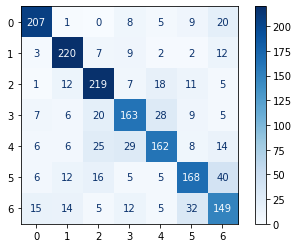

In [231]:

import numpy as np
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe1.fit(X_train, y_train), X_test, y_test,
                                 display_labels=tfidf_vector.get_feature_names(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [233]:
# import the necessary

import torch
from transformers import BertForMaskedLM, BertTokenizer

In [236]:
tokenizer = BertTokenizer.from_pretrained("pytorch", do_lower_case=False)
model = BertForMaskedLM.from_pretrained("pytorch")
model.eval()

Some weights of the model checkpoint at pytorch were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [2]:
import tensorflow as tf

In [ ]:
device_